In [42]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import little_things_functions as ltf
import math

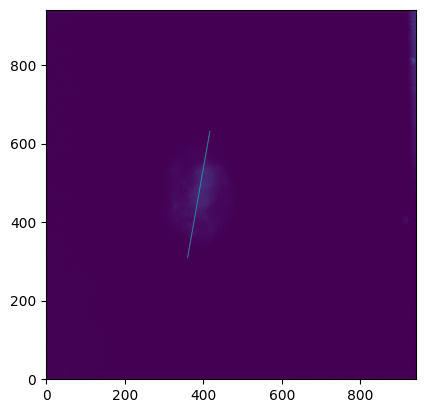

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


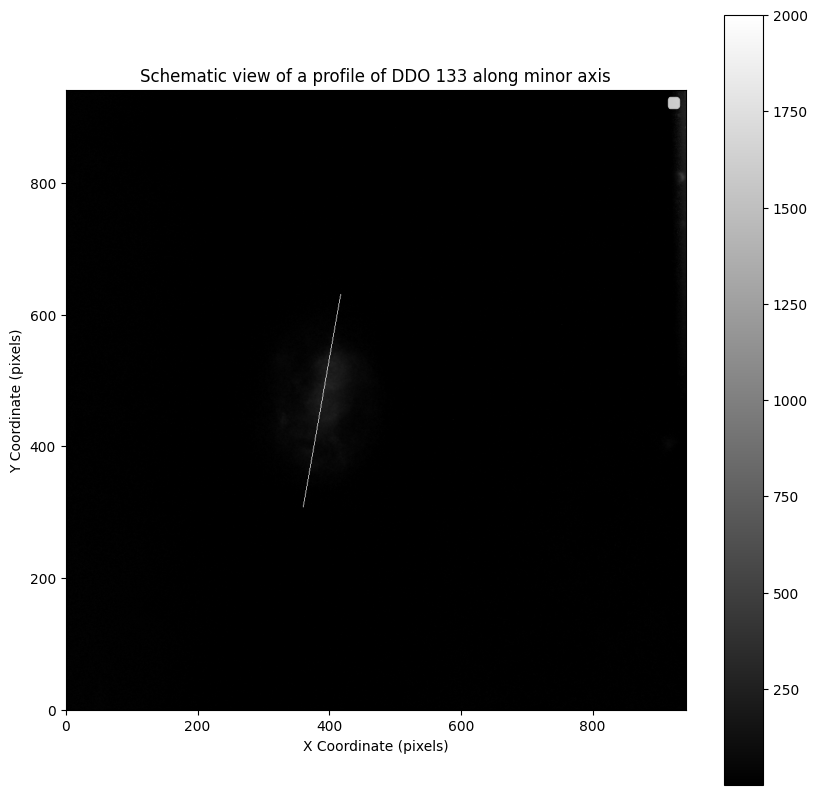

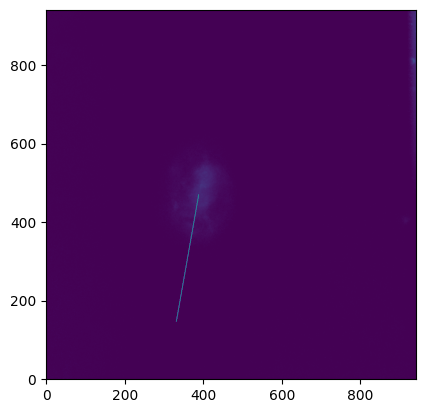

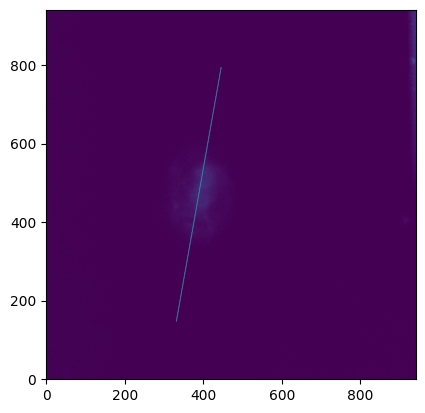

y_ax_left length: 324
y_ax_right length: 324
values_along_line_left length: 324
values_along_line_right length: 324
y_ax combined length: 648
values_along_line combined length: 648


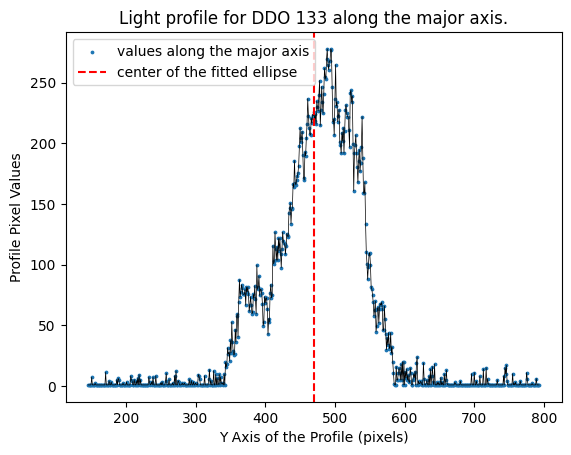

Threshold value: 142.77030992743408
Center of galaxy (Equal Area on both sides of the center line): 482


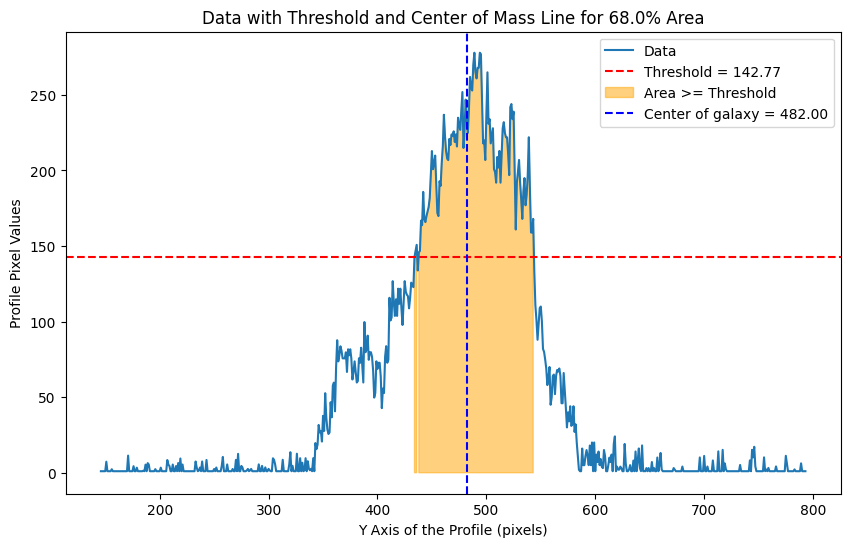

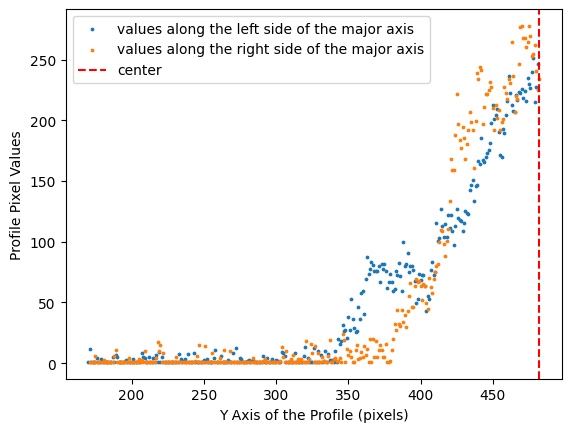

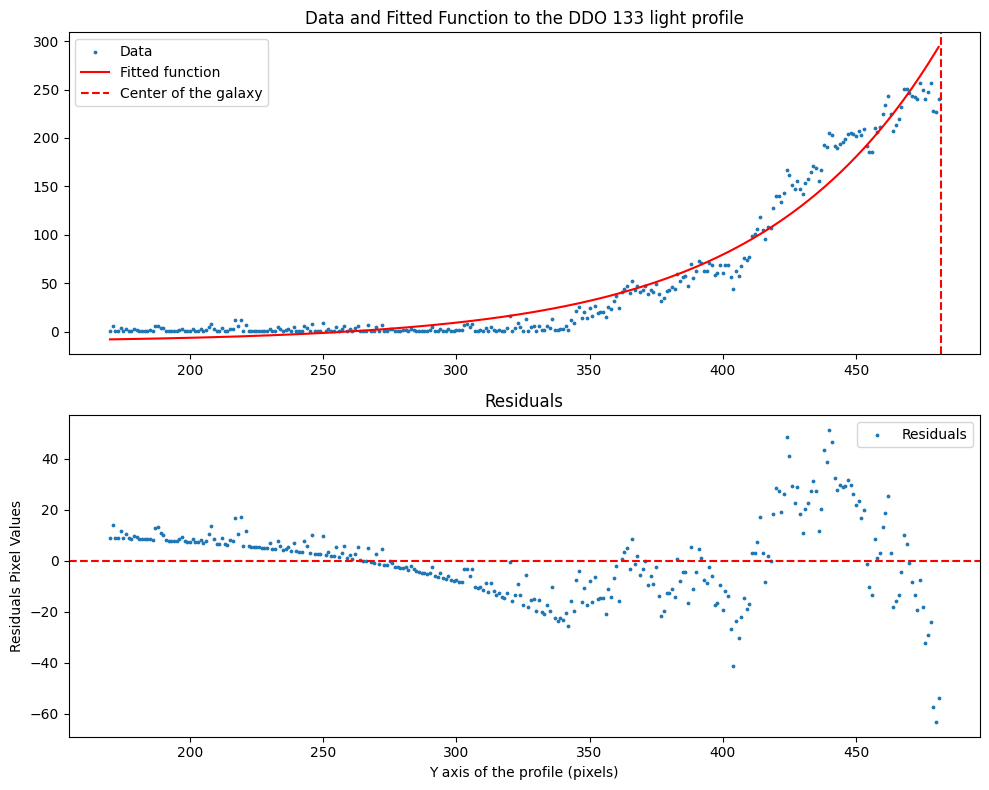

Exponential fit function is a * exp(b * (x - x0)) + c
a is 0.2210 +/- 916.9278
b is 0.0150 +/- 0.0004
c is -11.0002 +/- 1.8550
x0 is -0.6211 +/- 276900.6461
RD is 66.6142 pixels
RD for DDO 133 is 2.2340057123670056 kpc


In [43]:
galaxy_name = "DDO 133"
D = 6.1
x_start = 75
y_start = 150
a_half = 81
b_half = 51
theta_deg = -10 + 90 
X_center = 314 + x_start
y_center = 320 + y_start


visual_133 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 133\non_shifted_background_d133v.fits"))
theta_rad = np.radians(theta_deg)
list_of_ellipse_data = [theta_rad, a_half, b_half]
y_ax_left = np.arange(y_center - 2 * a_half, y_center)
y_ax_right = np.arange(y_center, y_center + 2*a_half)
y_ax = np.concatenate((y_ax_left, y_ax_right))

def get_line_values(array, X_center, y_center, y_ax, theta_rad): 
    m = np.tan(theta_rad)
    values = [] 
    x_list = [] 
    for y in y_ax: 
        x = int((y - y_center + m * X_center) / m)
        values.append(array[y, x]) 
        array[y, x] = 2000 
        x_list.append(x) 
    plt.imshow(array, origin = 'lower')
    plt.show()
    return values, x_list

get_line_values(visual_133, X_center, y_center, y_ax, theta_rad)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(visual_133, cmap='gray', origin='lower')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(" ")

plt.title(f"Schematic view of a profile of {galaxy_name} along minor axis")
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.legend()
plt.show()



DDO_133 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 133\non_shifted_background_d133v.fits"))


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def RD(image, n ,distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, galaxy_name, ratio=0.68, initial_guesses=[45, 0.1, 25, 0]):
    theta_rad, a, b = list_of_ellipse_data
    
     
    center_of_galaxy_y = int(center_of_galaxy_y)
    
    y_ax_left = np.arange(y_center - n * a_half, y_center)
    y_ax_right = np.arange(y_center, y_center + n*a_half)
    
    values_along_line_left, x_list_left = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y, y_ax_left, theta_rad)
    values_along_line_right, x_list_right = get_line_values(image, center_of_galaxy_x, center_of_galaxy_y, y_ax_right, theta_rad)
    
    y_ax = np.concatenate((y_ax_left, y_ax_right))
    x_ax = np.concatenate((x_list_left, x_list_right))
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))

    # Add print statements to debug the lengths
    print(f"y_ax_left length: {len(y_ax_left)}")
    print(f"y_ax_right length: {len(y_ax_right)}")
    print(f"values_along_line_left length: {len(values_along_line_left)}")
    print(f"values_along_line_right length: {len(values_along_line_right)}")
    print(f"y_ax combined length: {len(y_ax)}")
    print(f"values_along_line combined length: {len(values_along_line)}")

    if len(y_ax) == len(values_along_line):
        plt.scatter(y_ax, values_along_line, s=3, label='values along the major axis')
        plt.plot(y_ax, values_along_line, color="black", linewidth=0.5)
        plt.title(f"Light profile for {galaxy_name} along the major axis.")
        plt.axvline(x=center_of_galaxy_y, color='r', linestyle='--', label='center of the fitted ellipse')
        plt.xlabel("Y Axis of the Profile (pixels)")
        plt.ylabel("Profile Pixel Values")
        plt.legend()
        plt.show()
    else:
        print("The lengths of y_ax and values_along_line do not match.")
        print(len(y_ax))
        print(len(values_along_line))
        return
    
    values_along_line = np.array(values_along_line)
    y_ax = np.array(y_ax)
    
    total_area = np.trapz(values_along_line, x=y_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (y_ax[1] - y_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_y_ax = y_ax[values_along_line > threshold_value]
    
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_y = y_ax[com_index]
    center_of_mass_x = x_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy (Equal Area on both sides of the center line): {center_of_mass_y}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(y_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_y, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_y:.2f}')
    plt.legend()
    plt.xlabel("Y Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    y_ax_left = y_ax[:com_index]
    y_ax_right = y_ax[com_index:]

    if len(y_ax_left) > len(y_ax_right):
        delete = len(y_ax_left) - len(y_ax_right)
        y_ax_left = y_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(y_ax_left) < len(y_ax_right):
        delete = len(y_ax_right) - len(y_ax_left)
        y_ax_right = y_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    flipped_y_ax_right = []
    for i in range(len(y_ax_right)):
        y = (2 * center_of_mass_y - y_ax_right[i])
        flipped_y_ax_right.append(int(y))

    flipped_y_ax_right = np.array(flipped_y_ax_right)

    plt.scatter(y_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_y_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_y, color='r', linestyle='--', label='center')
    plt.xlabel("Y Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.legend()
    plt.show()
    
    x1 = y_ax_left  
    x2 = flipped_y_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2) / 2
    
    def exponential_func(x, a, b, c, x0):
        return a * np.exp(b * (x - x0)) + c

    popt, pcov = curve_fit(exponential_func, y_ax_left, mean_y, p0=initial_guesses)

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(y_ax_left, mean_y, s=3, label='Data')
    plt.plot(y_ax_left, exponential_func(y_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_y, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y - exponential_func(y_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(y_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('Y axis of the profile (pixels)') 
    plt.ylabel('Residuals Pixel Values') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
    print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")
    print(f"RD is {1/popt[1]:.4f} pixels")
    
    RD_pixels = 1 / popt[1]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((distance * RD_arcsec) / 206265) * 1000
    print(f"RD for {galaxy_name} is {RD_value} kpc")
    return RD_pixels , RD_arcsec , y_ax_left, mean_y

RD_pixels , RD_arcsec, x_values, y_values = RD(DDO_133, 4,D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name, initial_guesses=[1, 0.06, 25, 0])

312 312


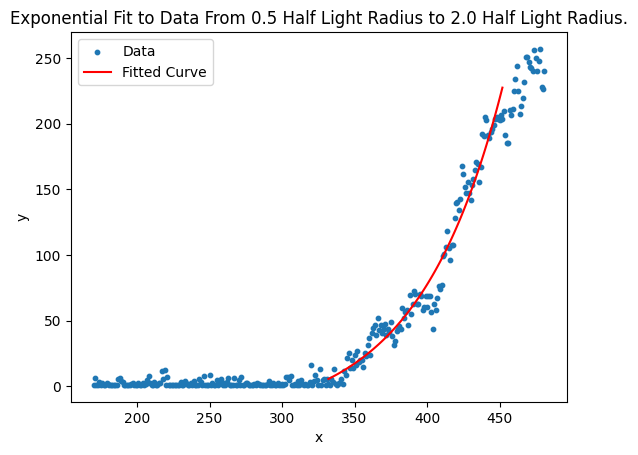

RD for DDO 133 is 1.9573916030154255 kpc for 0.5 Half Light Radius to 2.0 Half Light Radius 


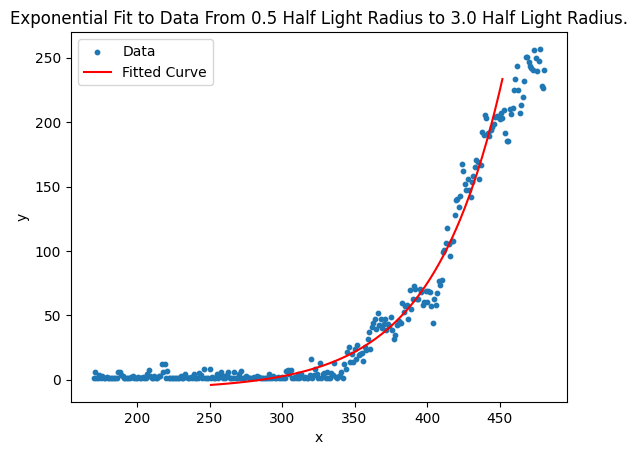

RD for DDO 133 is 1.6260946055168923 kpc for 0.5 Half Light Radius to 3.0 Half Light Radius 


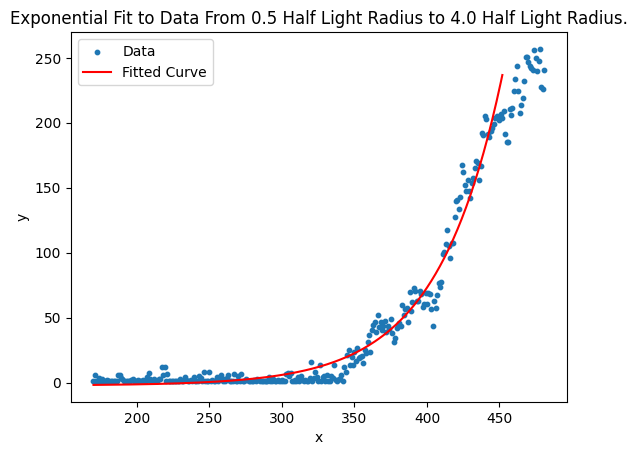

RD for DDO 133 is 1.5101403649698943 kpc for 0.5 Half Light Radius to 4.0 Half Light Radius 


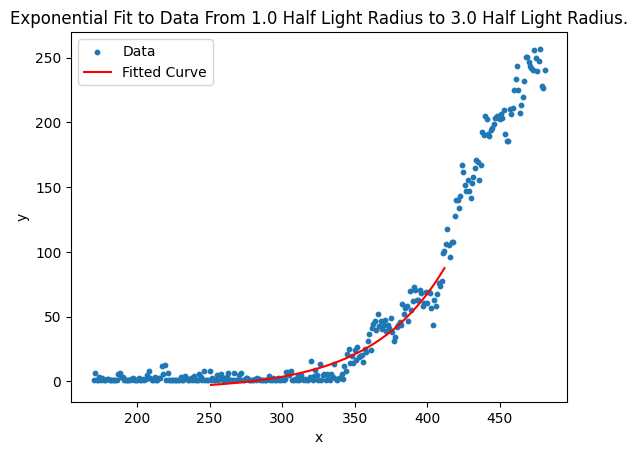

RD for DDO 133 is 1.6871192290279777 kpc for 1.0 Half Light Radius to 3.0 Half Light Radius 


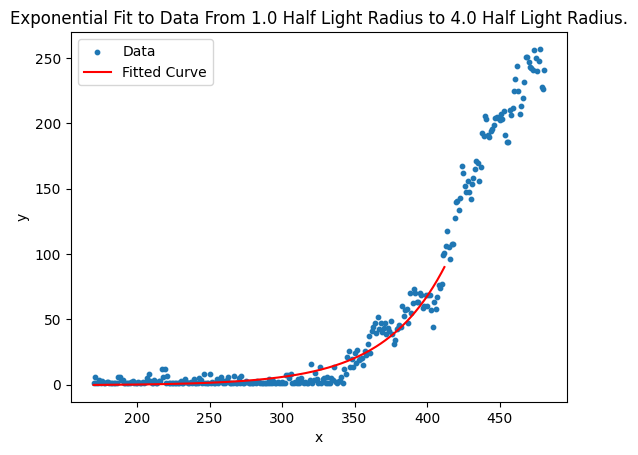

RD for DDO 133 is 1.4151437769436825 kpc for 1.0 Half Light Radius to 4.0 Half Light Radius 


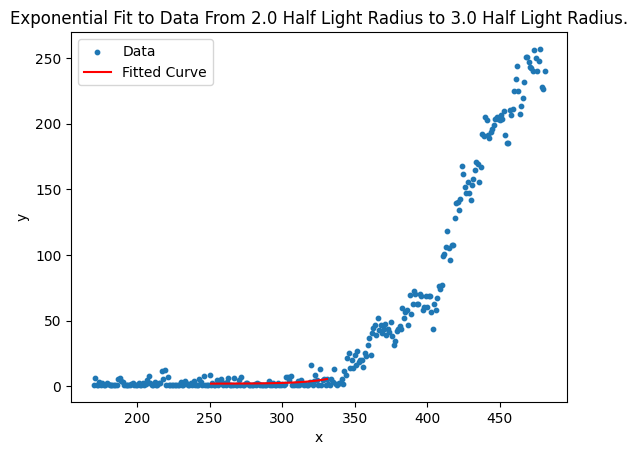

RD for DDO 133 is 0.5720650501464525 kpc for 2.0 Half Light Radius to 3.0 Half Light Radius 


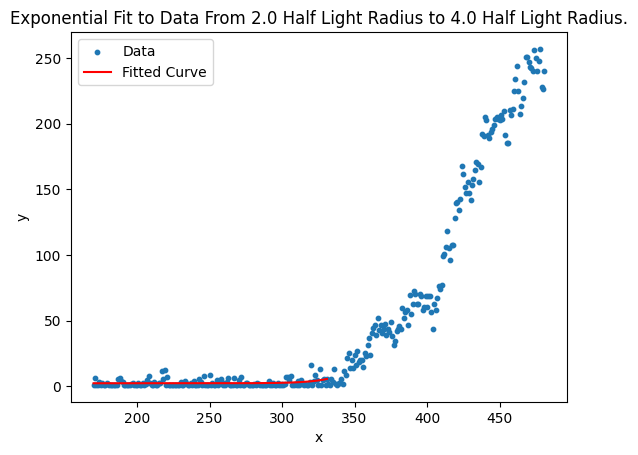

RD for DDO 133 is 0.4639543151098045 kpc for 2.0 Half Light Radius to 4.0 Half Light Radius 


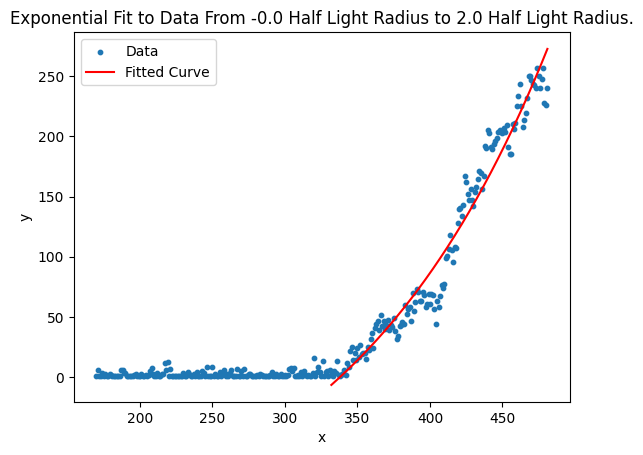

RD for DDO 133 is 4.839406829182427 kpc for -0.0 Half Light Radius to 2.0 Half Light Radius 


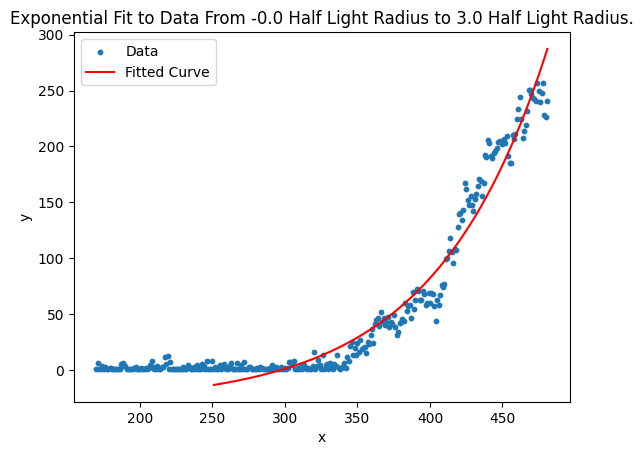

RD for DDO 133 is 2.610939178919989 kpc for -0.0 Half Light Radius to 3.0 Half Light Radius 


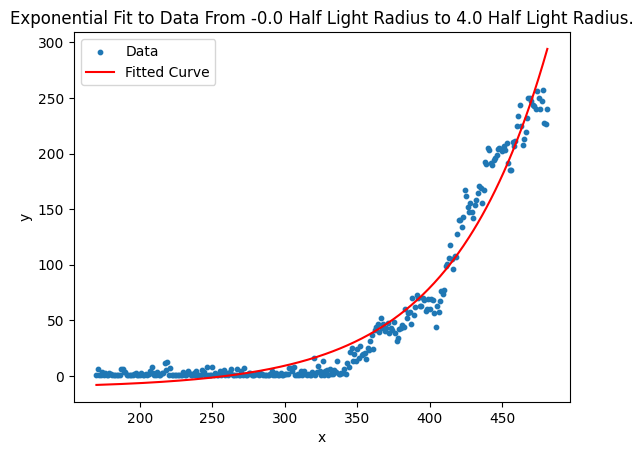

RD for DDO 133 is 2.2340057123670056 kpc for -0.0 Half Light Radius to 4.0 Half Light Radius 
  Range (half light)  RD (kpc)       RMSE
0         0.5 - 2.0   1.957392  12.113437
1          0.5 - 3.0  1.626095  10.156387
2          0.5 - 4.0  1.510140   9.127438
3          1.0 - 3.0  1.687119   7.633016
4          1.0 - 4.0  1.415144   6.748887
5          2.0 - 3.0  0.572065   2.581814
6          2.0 - 4.0  0.463954   2.504368
7          0.0 - 2.0  4.839407  16.099026
8          0.0 - 3.0  2.610939  16.261991
9          0.0 - 4.0  2.234006  15.559288
Paper value 2.15 kpc


In [44]:
def exponential_func(x, a, b, c, x0):
    return a * np.exp(b * (x - x0)) + c

from sklearn.metrics import mean_squared_error
pixel_scale = 1.134

bounds = [[4-2, 4-0.5], [4-3,4-0.5], [4-4, 4-0.5], [4-3,4-1], [4-4, 4-1], [4-3,4-2], [4-4, 4-2] , [4-2, 4-0], [4-3,4-0], [4-4, 4-0]]
print(len(y_values) , len(x_values))
RD_list = []
RMSE_list = []
for bound in bounds:
    lower_bound = float(bound[0])
    higher_bound = float(bound[1])
    x_filtered = x_values[int(lower_bound*a_half) : int(higher_bound * a_half)]
    y_filtered = y_values[int(lower_bound*a_half) : int(higher_bound * a_half)]


    popt, pcov = curve_fit(exponential_func, x_filtered, y_filtered, p0=(1, 0.06, 25, 0))
    y_pred = exponential_func(x_filtered, *popt) 
    rmse = np.sqrt(mean_squared_error(y_filtered, y_pred)) 
    RMSE_list.append(rmse)
    # Plot the results
    plt.scatter(x_values, y_values, label='Data', s=10)
    plt.plot(x_filtered, exponential_func(x_filtered, *popt), 'r-', label='Fitted Curve')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Exponential Fit to Data From {-(higher_bound-4)} Half Light Radius to {-(lower_bound-4)} Half Light Radius.')
    plt.show()
    RD_pixels = 1/popt[1]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((D * RD_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD_value} kpc for {-(higher_bound-4)} Half Light Radius to {-(lower_bound-4)} Half Light Radius ")
    RD_list.append(RD_value)
import pandas as pd

# Create a dictionary of data
data = {
    'Range (half light)': [' 0.5 - 2.0 ', '0.5 - 3.0', '0.5 - 4.0', '1.0 - 3.0', '1.0 - 4.0', '2.0 - 3.0', '2.0 - 4.0', '0.0 - 2.0' , '0.0 - 3.0', '0.0 - 4.0'],
    'RD (kpc)': RD_list,
    'RMSE' : RMSE_list
    
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame as a table
print(df)

print("Paper value 2.15 kpc")


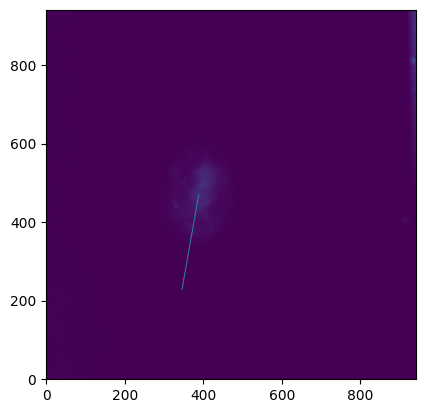

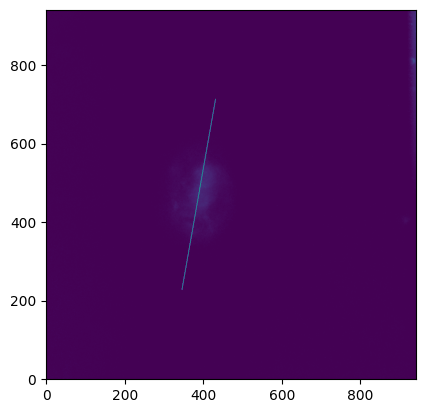

y_ax_left length: 243
y_ax_right length: 243
values_along_line_left length: 243
values_along_line_right length: 243
y_ax combined length: 486
values_along_line combined length: 486


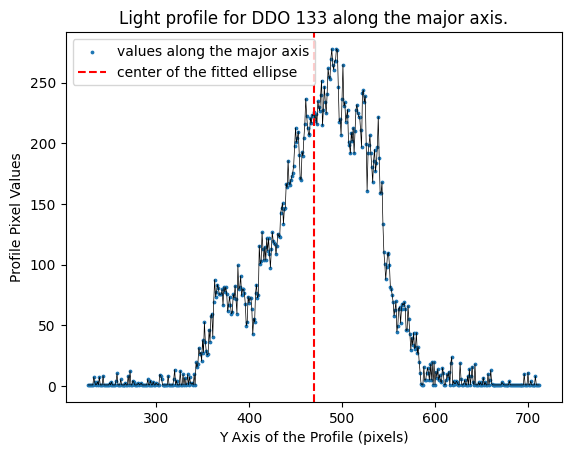

Threshold value: 145.77730936777803
Center of galaxy (Equal Area on both sides of the center line): 482


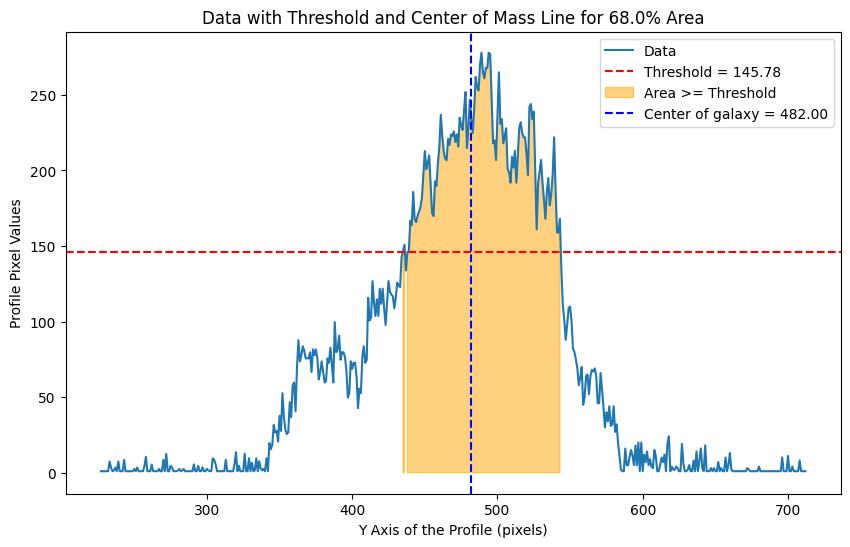

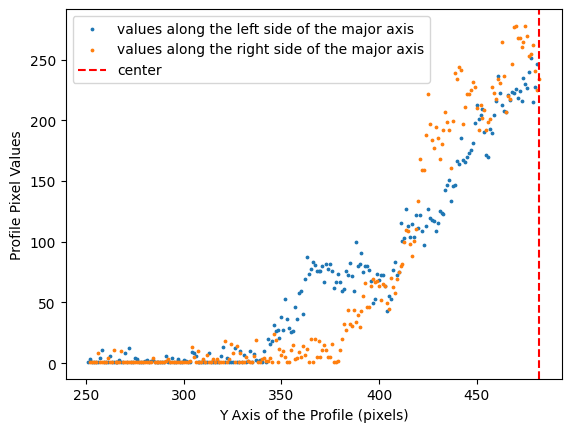

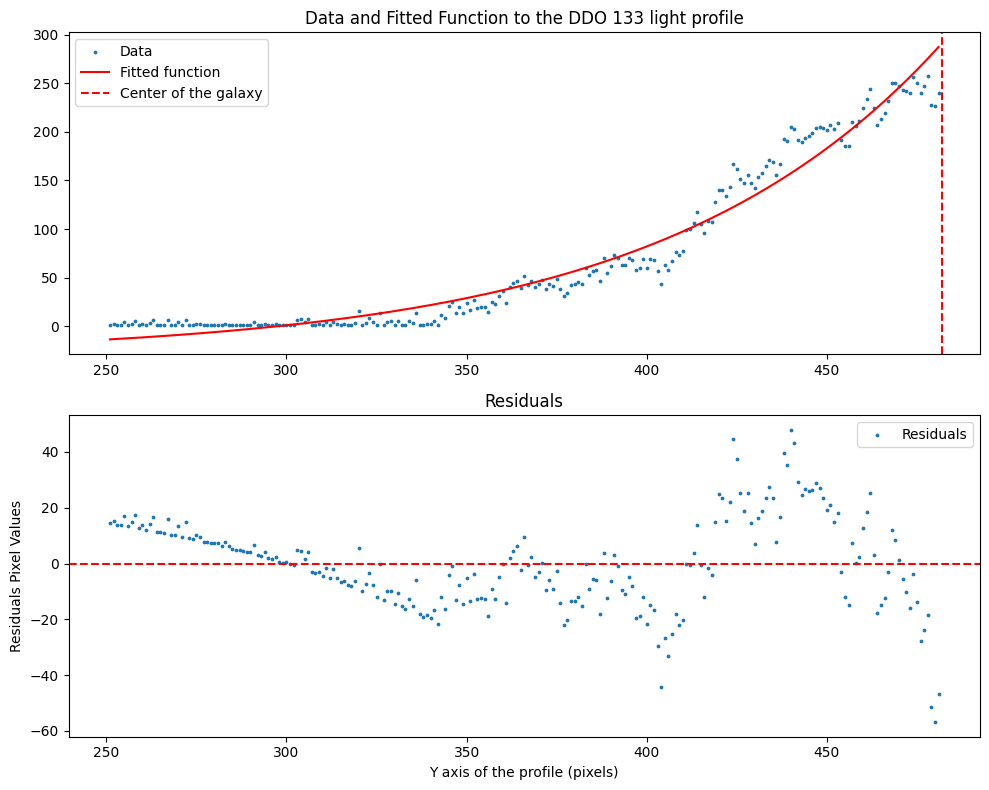

Exponential fit function is a * exp(b * (x - x0)) + c
a is 0.6543 +/- 649.1640
b is 0.0128 +/- 0.0005
c is -29.9171 +/- 4.1267
x0 is -0.4070 +/- 77114.0716
RD is 77.8537 pixels
RD for DDO 133 is 2.610939178919989 kpc


In [45]:
DDO_133 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 133\non_shifted_background_d133v.fits"))
RD_pixels , RD_arcsec , y_values , x_values = RD (DDO_133, 3, D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name, initial_guesses=[1, 0.06, 25, 0])

sigma is 51.31420227301612


C:\Users\AYSAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_minpack_py.py:966: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
C:\Users\AYSAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_minpack_py.py:1004: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq


RD values: [0.013973529248366078, 0.013973529421991203, 0.013973529421991203, 0.013973529421991203, 0.013973529248366078, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529421991203, 0.013973529421991203, 0.013973529421991203, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529421991203, 0.013973529421991203, 0.013973529421991203, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529248366078, 0.013973529421991203, 0.013973529248366078, 0.013973529248366078

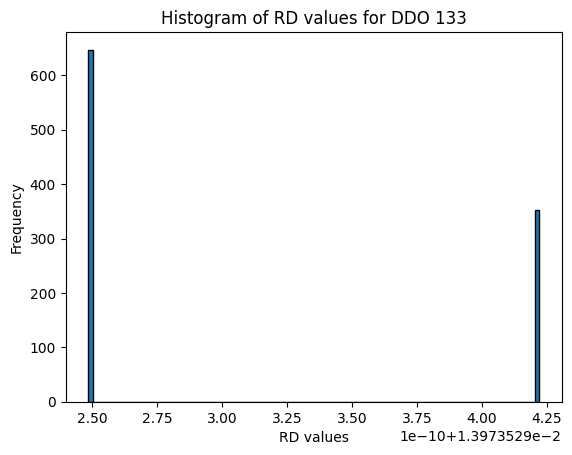

In [48]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Define the exponential function
def exponential_func(x, a, b, c, x0):
    return a * np.exp(b * (x - x0)) + c

# Assume DDO_101, y_values, x_values, pixel_scale, D, and galaxy_name are defined
sigma = np.std(DDO_133)
print("sigma is", sigma)

# Number of iterations
n = 1000

# Lists to store the fitted parameters
a_list = []
b_list = []
c_list = []
x0_list = []
RD_list = []

# Loop for bootstrapping
for i in range(n):
    # Generate unique random noise for each data point from the normal distribution
    noise = np.random.normal(0, sigma, size=len(y_values))
    # Add unique noise to each data point in y_values
    y_noisy = y_values + noise
    # Fit the exponential function to the noisy data with increased maxfev
    popt, pcov = curve_fit(exponential_func, x_values, y_noisy, p0=(1, 2.4, 25, 0), maxfev=5000)
    
    # Append the parameters to the respective lists
    a_list.append(popt[0])
    b_list.append(popt[1])
    RD_pixels = 1/popt[1]
    RD_arcsec = RD_pixels * pixel_scale
    RD_value = ((D * RD_arcsec) / 206265)*1000
    RD_list.append(RD_value)
    c_list.append(popt[2])
    x0_list.append(popt[3])

# Print RD values and plot the histogram
print(f"RD values: {RD_list}")
plt.hist(RD_list, bins=100, edgecolor='k')
plt.xlabel('RD values')
plt.ylabel('Frequency')
plt.title(f'Histogram of RD values for {galaxy_name}')
plt.show()
